# 명함

In [1]:
!pip install easyocr

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 16.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 813.9/813.9 kB 19.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 146.0/146.0 kB 8.2 MB/s eta 0:00:00


In [2]:
from matplotlib import pyplot as plt
from imutils.perspective import four_point_transform
from imutils.contours import sort_contours
import imutils
from easyocr import Reader
import cv2
import requests
import numpy as np
from PIL import ImageFont, ImageDraw, Image

In [3]:
def plt_imshow(title='image', img=None, figsize=(8 ,5)):
    plt.figure(figsize=figsize)

    if type(img) == list:
        if type(title) == list:
            titles = title
        else:
            titles = []

            for i in range(len(img)):
                titles.append(title)

        for i in range(len(img)):
            if len(img[i].shape) <= 2:
                rgbImg = cv2.cvtColor(img[i], cv2.COLOR_GRAY2RGB)
            else:
                rgbImg = cv2.cvtColor(img[i], cv2.COLOR_BGR2RGB)

            plt.subplot(1, len(img), i + 1), plt.imshow(rgbImg)
            plt.title(titles[i])
            plt.xticks([]), plt.yticks([])

        plt.show()
    else:
        if len(img.shape) < 3:
            rgbImg = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
        else:
            rgbImg = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        plt.imshow(rgbImg)
        plt.title(title)
        plt.xticks([]), plt.yticks([])
        plt.show()


def make_scan_image(image, width, ksize=(5,5), min_threshold=75, max_threshold=200):
  image_list_title = []
  image_list = []

  image = imutils.resize(image, width=width)
  ratio = org_image.shape[1] / float(image.shape[1])

  # 이미지를 grayscale로 변환하고 blur를 적용
  # 모서리를 찾기위한 이미지 연산
  gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
  blurred = cv2.GaussianBlur(gray, ksize, 0)
  edged = cv2.Canny(blurred, min_threshold, max_threshold)

  image_list_title = ['gray', 'blurred', 'edged']
  image_list = [gray, blurred, edged]

  # contours를 찾아 크기순으로 정렬
  cnts = cv2.findContours(edged.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
  cnts = imutils.grab_contours(cnts)
  cnts = sorted(cnts, key=cv2.contourArea, reverse=True)

  findCnt = None

  # 정렬된 contours를 반복문으로 수행하며 4개의 꼭지점을 갖는 도형을 검출
  for c in cnts:
    peri = cv2.arcLength(c, True)
    approx = cv2.approxPolyDP(c, 0.02 * peri, True)

    # contours가 크기순으로 정렬되어 있기때문에 제일 첫번째 사각형을 영역으로 판단하고 break
    if len(approx) == 4:
      findCnt = approx
      break


  # 만약 추출한 윤곽이 없을 경우 오류
  if findCnt is None:
    raise Exception(("Could not find outline."))


  output = image.copy()
  cv2.drawContours(output, [findCnt], -1, (0, 255, 0), 2)

  image_list_title.append("Outline")
  image_list.append(output)

  # 원본 이미지에 찾은 윤곽을 기준으로 이미지를 보정
  transform_image = four_point_transform(org_image, findCnt.reshape(4, 2) * ratio)

  plt_imshow(image_list_title, image_list)
  plt_imshow("Transform", transform_image)

  return transform_image

In [4]:
def putText(cv_img, text, x, y, color=(0, 0, 0), font_size=22):
  # Colab이 아닌 Local에서 수행 시에는 gulim.ttc 를 사용하면 됩니다.
  # font = ImageFont.truetype("fonts/gulim.ttc", font_size)
  font = ImageFont.truetype('/usr/share/fonts/truetype/nanum/NanumGothicBold.ttf', font_size)
  img = Image.fromarray(cv_img)

  draw = ImageDraw.Draw(img)
  draw.text((x, y), text, font=font, fill=color)

  cv_img = np.array(img)

  return cv_img

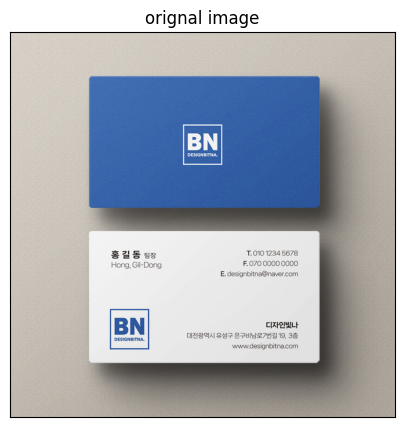

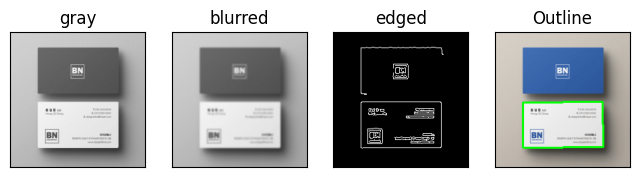

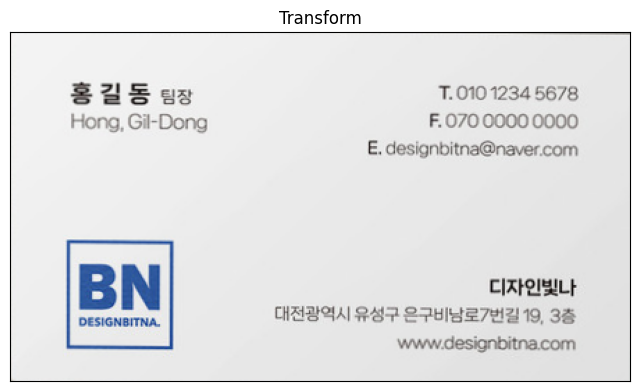

In [16]:
url = 'https://cdn.imweb.me/thumbnail/20230223/1ab105e7023e0.jpg'

image_nparray = np.asarray(bytearray(requests.get(url).content), dtype=np.uint8)
org_image = cv2.imdecode(image_nparray, cv2.IMREAD_COLOR)
plt_imshow("orignal image", org_image)

business_card_image = make_scan_image(org_image, width=200, ksize=(5, 5), min_threshold=20, max_threshold=100)


In [17]:
langs = ['ko', 'en']

print("[INFO] OCR'ing input image...")
reader = Reader(lang_list=langs, gpu=True)
results = reader.readtext(business_card_image)

[INFO] OCR'ing input image...


In [18]:
results

[([[40, 32], [134, 32], [134, 56], [40, 56]], '홍길 동 팀장', 0.4664881172671638),
 ([[307, 35], [411, 35], [411, 53], [307, 53]],
  'T.0101234 5678',
  0.8170649260948052),
 ([[41, 55], [145, 55], [145, 76], [41, 76]],
  'Hong Gil-Dong',
  0.6655070357047512),
 ([[301, 55], [411, 55], [411, 73], [301, 73]],
  '507000000000',
  0.6426776602814461),
 ([[269, 77], [411, 77], [411, 93], [269, 93]],
  'designbitna@navercom',
  0.9386323093648077),
 ([[49, 161], [115, 161], [115, 205], [49, 205]], 'BN', 0.9852447107595314),
 ([[341, 173], [411, 173], [411, 193], [341, 193]],
  '디자인빛나',
  0.8677518350872102),
 ([[49, 203], [111, 203], [111, 215], [49, 215]],
  'DESIGNaITNA',
  0.8679316062528847),
 ([[189, 193], [409, 193], [409, 213], [189, 213]],
  '대전광의시 유성구 은구비남로7번길 19 33',
  0.6220529150637347),
 ([[277, 217], [411, 217], [411, 233], [277, 233]],
  'Wdesgnbitnacom',
  0.9762135815981405)]

In [22]:
simple_results = reader.readtext(business_card_image, detail = 0)
simple_results

['홍길 동 팀장',
 'T.0101234 5678',
 'Hong Gil-Dong',
 '507000000000',
 'designbitna@navercom',
 'BN',
 '디자인빛나',
 'DESIGNaITNA',
 '대전광의시 유성구 은구비남로7번길 19 33',
 'Wdesgnbitnacom']

In [28]:
# loop over the results
for (bbox, text, prob) in results:
  print("[INFO] {:.4f}: {}".format(prob, text))

  (tl, tr, br, bl) = bbox
  tl = (int(tl[0]), int(tl[1]))
  tr = (int(tr[0]), int(tr[1]))
  br = (int(br[0]), int(br[1]))
  bl = (int(bl[0]), int(bl[1]))

# 추출한 영역에 사각형을 그리고 인식한 글자를 표기합니다.
cv2.rectangle(business_card_image, tl, br, (0, 255, 0), 2)
# business_card_image = putText(business_card_image, text, tl[0], tl[1] - 60, (0, 255, 0), 50)
cv2.putText(business_card_image, text, (tl[0], tl[1] - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0, 255, 0), 2)

[INFO] 0.4665: 홍길 동 팀장
[INFO] 0.8171: T.0101234 5678
[INFO] 0.6655: Hong Gil-Dong
[INFO] 0.6427: 507000000000
[INFO] 0.9386: designbitna@navercom
[INFO] 0.9852: BN
[INFO] 0.8678: 디자인빛나
[INFO] 0.8679: DESIGNaITNA
[INFO] 0.6221: 대전광의시 유성구 은구비남로7번길 19 33
[INFO] 0.9762: Wdesgnbitnacom


array([[[205, 210, 216],
        [231, 235, 237],
        [243, 244, 244],
        ...,
        [116, 121, 123],
        [115, 119, 122],
        [115, 119, 122]],

       [[213, 219, 223],
        [240, 243, 244],
        [242, 241, 241],
        ...,
        [165, 169, 170],
        [163, 166, 167],
        [164, 168, 169]],

       [[227, 230, 234],
        [242, 241, 244],
        [242, 242, 242],
        ...,
        [234, 236, 237],
        [233, 234, 235],
        [234, 235, 236]],

       ...,

       [[208, 213, 218],
        [230, 232, 233],
        [236, 236, 236],
        ...,
        [225, 225, 225],
        [226, 226, 226],
        [221, 222, 220]],

       [[189, 195, 200],
        [221, 226, 229],
        [232, 235, 237],
        ...,
        [225, 225, 225],
        [225, 225, 225],
        [222, 223, 221]],

       [[170, 177, 183],
        [195, 201, 205],
        [216, 220, 222],
        ...,
        [224, 224, 224],
        [224, 224, 224],
        [223, 224, 222]]

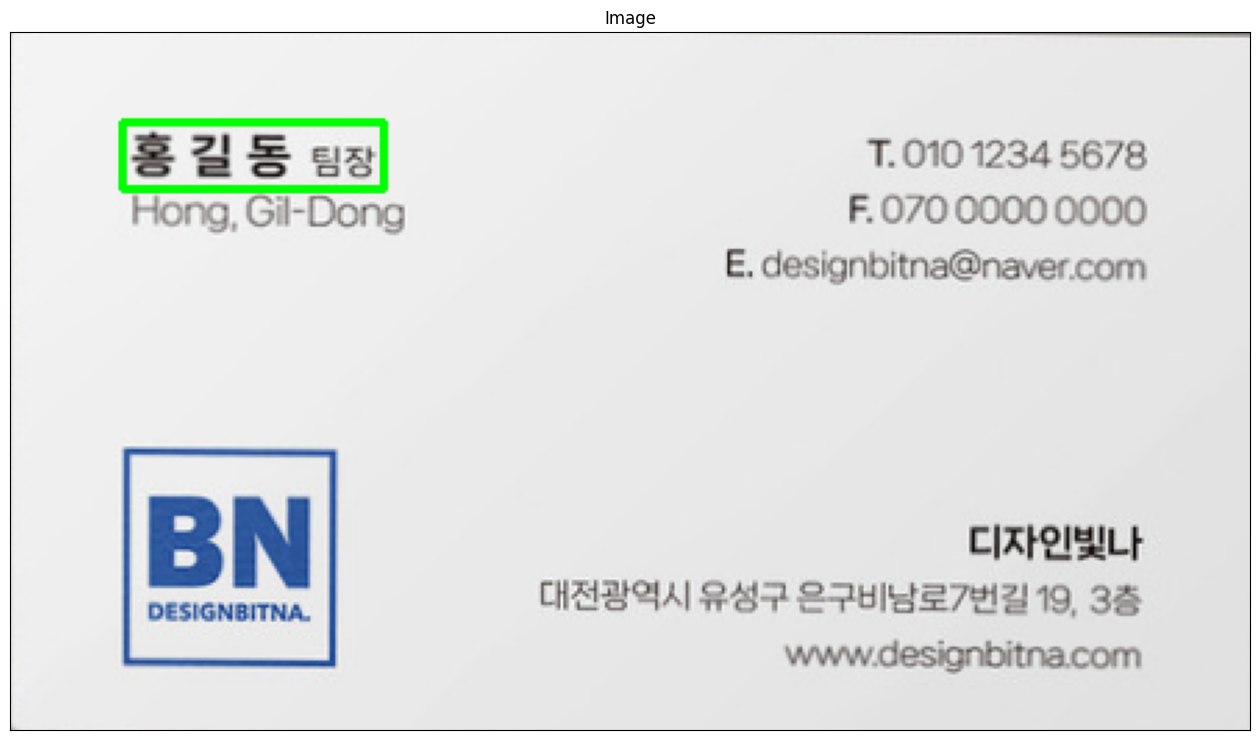

In [24]:
plt_imshow("Image", business_card_image, figsize=(16,10))

# 주민등록증


In [58]:
def make_scan_image(file_path, width, ksize=(5,5), min_threshold=75, max_threshold=200):
    image_list_title = []
    image_list = []

    image = cv2.imread(file_path)  # 이미지 파일을 로드합니다.
    image = imutils.resize(image, width=width)
    ratio = org_image.shape[1] / float(image.shape[1])

    # 이미지를 grayscale로 변환하고 blur를 적용
    # 모서리를 찾기위한 이미지 연산
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    blurred = cv2.GaussianBlur(gray, ksize, 0)
    edged = cv2.Canny(blurred, min_threshold, max_threshold)

    image_list_title = ['gray', 'blurred', 'edged']
    image_list = [gray, blurred, edged]

    # contours를 찾아 크기순으로 정렬
    cnts = cv2.findContours(edged.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    cnts = sorted(cnts, key=cv2.contourArea, reverse=True)

    findCnt = None

    # 정렬된 contours를 반복문으로 수행하며 4개의 꼭지점을 갖는 도형을 검출
    for c in cnts:
        peri = cv2.arcLength(c, True)
        approx = cv2.approxPolyDP(c, 0.02 * peri, True)

        # contours가 크기순으로 정렬되어 있기 때문에 제일 첫번째 사각형을 영역으로 판단하고 break
        if len(approx) == 4:
            findCnt = approx
            break

    # 만약 추출한 윤곽이 없을 경우 오류
    if findCnt is None:
        raise Exception(("Could not find outline."))

    output = image.copy()
    cv2.drawContours(output, [findCnt], -1, (0, 255, 0), 2)

    image_list_title.append("Outline")
    image_list.append(output)

    # 원본 이미지에 찾은 윤곽을 기준으로 이미지를 보정
    transform_image = four_point_transform(org_image, findCnt.reshape(4, 2) * ratio)

    plt_imshow(image_list_title, image_list)
    plt_imshow("Transform", transform_image)

    return transform_image


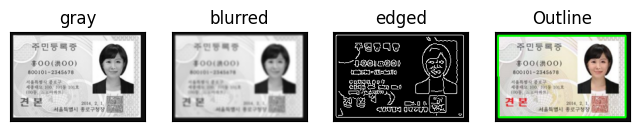

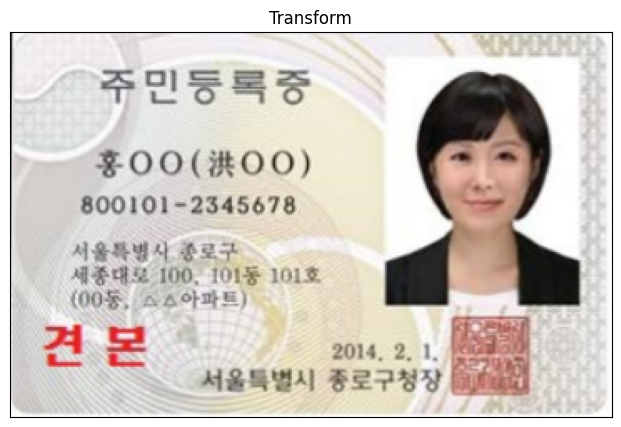

In [66]:
path = '/content/img.jpg'

# image_nparray = np.asarray(bytearray(requests.get(url).content), dtype=np.uint8)
# org_image = cv2.imdecode(image_nparray, cv2.IMREAD_COLOR)
# plt_imshow("orignal image", org_image)

# business_card_image = make_scan_image(org_image, width=200, ksize=(5, 5), min_threshold=20, max_threshold=100)


# org_image = cv2.imread(path)

# 이미지 처리를 위해 make_scan_image 함수 호출
# perspective_image = perspective_correction(path,)
jumin_image = make_scan_image(path, width=200, ksize=(5, 5), min_threshold=20, max_threshold=100)

In [67]:
langs = ['ko', 'en']

print("[INFO] OCR'ing input image...")
reader = Reader(lang_list=langs, gpu=True)
results = reader.readtext(jumin_image)

[INFO] OCR'ing input image...


In [68]:
result_text_list = []

for (bbox, text, prob) in results:
  # print("[INFO] {:.4f}: {}".format(prob, text))
  result_text_list.append(text)

  (tl, tr, br, bl) = bbox
  tl = (int(tl[0]), int(tl[1]))
  tr = (int(tr[0]), int(tr[1]))
  br = (int(br[0]), int(br[1]))
  bl = (int(bl[0]), int(bl[1]))

print(result_text_list[2])
print(type(result_text_list[2]))

# # 추출한 영역에 사각형을 그리고 인식한 글자를 표기합니다.
# cv2.rectangle(business_card_image, tl, br, (0, 255, 0), 2)
# # business_card_image = putText(business_card_image, text, tl[0], tl[1] - 60, (0, 255, 0), 50)
# cv2.putText(business_card_image, text, (tl[0], tl[1] - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0, 255, 0), 2)

800101-2345678
<class 'str'>


### 주민등록번호 유효성 검사
* 마지막 자리를 제외하고 순서대로 2 3 4 5 6 7 8 9
* 2 3 4 5 의 가중치를 곱함
* 각 자리수에 가중치를 곱한 수를 모두 더함
* 102 % 11 (11로 나눈 나머지 값을 구함)
* 해당 값을 11에서 뺌, 단 값이 두 자리인 경우
* 10으로 나눈 나머지 값을 구함
* 주민번호의 마지막 자리와 일치하면 유효

In [69]:
jumin_no = list(result_text_list[2].replace('-',''))
num = [2, 3, 4, 5, 6, 7, 8, 9, 2, 3, 4, 5]
total = 0

for i in range(12):
  sum = int(jumin_no[i]) * num[i]
  total += sum
print(f'숫자를 모두 더한 값은 {total}입니다')

# 뺀 값이 두자리 라면 다시 10을 나눈 나머지값을 구함
num = (11 - (total % 11)) % 10

if int(jumin_no[-1]) == num:
  print('유효한 주민번호 입니다')
else:
  print('주민번호를 확인하세요')

숫자를 모두 더한 값은 153입니다
주민번호를 확인하세요
